# Dataset link :
https://www.kaggle.com/datasets/mlippo/car-accidents-in-brazil-2017-2023

# The imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Reading and chacking the data

In [3]:
df = pd.read_csv('accidents_2017_to_2023_english.csv')

In [4]:
df.isnull().sum()

inverse_data             0
week_day                 0
hour                     0
state                    0
road_id                990
km                     990
city                     0
cause_of_accident        0
type_of_accident         0
victims_condition        0
weather_timestamp        0
road_direction           0
wheather_condition       0
road_type                0
road_delineation         0
people                   0
deaths                   0
slightly_injured         0
severely_injured         0
uninjured                0
ignored                  0
total_injured            0
vehicles_involved        0
latitude                 0
longitude                0
regional                10
police_station        1310
dtype: int64

In [5]:
df.head()

,inverse_data,week_day,hour,state,road_id,km,city,cause_of_accident,type_of_accident,victims_condition,...,slightly_injured,severely_injured,uninjured,ignored,total_injured,vehicles_involved,latitude,longitude,regional,police_station
0,2017-01-01,sunday,01:45:00,RS,116.0,"34,9",VACARIA,Mechanical loss/defect of vehicle,Rear-end collision,With injured victims,...,4,0,2,0,4,2,-28.50712,-50.94118,SPRF-RS,DEL05-RS
1,2017-01-01,sunday,01:00:00,PR,376.0,636,TIJUCAS DO SUL,Incompatible velocity,Run-off-road,With dead victims,...,0,0,1,0,0,2,-25.75400,-49.12660,SPRF-PR,DEL01-PR
2,2017-01-01,sunday,04:40:00,BA,101.0,65,ENTRE RIOS,Driver was sleeping,Head-on collision,With dead victims,...,1,1,2,0,2,2,-11.96180,-38.09530,SPRF-BA,DEL01-BA
3,2017-01-01,sunday,06:30:00,PA,316.0,"72,5",CASTANHAL,Driver's lack of attention to conveyance,Side impact collision,With dead victims,...,0,0,3,0,0,3,-1.28998,-47.83483,SPRF-PA,DEL01-PA
4,2017-01-01,sunday,09:00:00,GO,20.0,"220,5",POSSE,Road's defect,Collision with fixed object,With injured victims,...,2,1,0,0,3,1,-14.14221,-46.32259,SPRF-DF,DEL02-DF


# Cleaning the data

In [6]:
def load_and_preprocess_data(df):
    """Preprocess the dataframe for analysis"""
    df.dropna(inplace=True)
    # Calculate total casualties without datetime conversion
    df['total_casualties'] = df['deaths'] + df['slightly_injured'] + df['severely_injured']
    
    # Convert hour to numeric if it isn't already
    try:
        df['hour'] = pd.to_numeric(df['hour'])
    except:
        # If conversion fails, we'll keep it as is
        pass
    
    return df

df = load_and_preprocess_data(df)

# Basic analysis

In [7]:
def basic_statistics(df):
    """Generate basic statistics about accidents"""
    stats = {
        'Total Accidents': len(df),
        'Total Deaths': df['deaths'].sum(),
        'Total Injured': df['total_injured'].sum(),
        'Average Vehicles per Accident': df['vehicles_involved'].mean(),
        'Most Common Cause': df['cause_of_accident'].mode().iloc[0],
        'Most Dangerous State': df.groupby('state')['deaths'].sum().idxmax()
    }
    return pd.Series(stats)

basic_statistics(df)

Total Accidents                                                    460929
Total Deaths                                                        36542
Total Injured                                                      505048
Average Vehicles per Accident                                    1.645789
Most Common Cause                Driver's lack of attention to conveyance
Most Dangerous State                                                   MG
dtype: object

# Temporal analysis

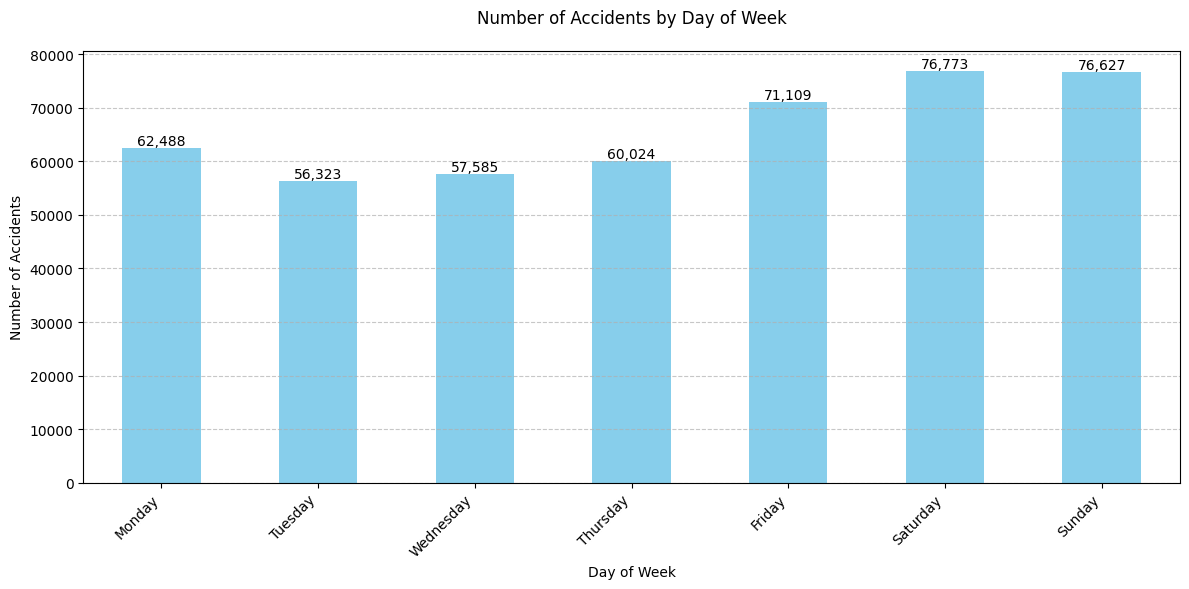

In [ ]:
def temporal_analysis(df):
    """Create visualizations for temporal patterns with NaN handling"""
    # Weekly distribution
    plt.figure(figsize=(12, 6))
    
    # Define correct order of days
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    # Count accidents by day and reindex to ensure correct order
    weekly_counts = df['week_day'].value_counts().reindex(day_order)
    
    # Fill NaN values with 0
    weekly_counts = weekly_counts.fillna(0)
    
    # Create bar plot
    ax = weekly_counts.plot(kind='bar', color='skyblue')
    
    # Customize the plot
    plt.title('Number of Accidents by Day of Week', pad=20)
    plt.xlabel('Day of Week')
    plt.ylabel('Number of Accidents')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on top of each bar
    for i, v in enumerate(weekly_counts):
        if v > 0:  # Only add label if value is greater than 0
            ax.text(i, v, f'{int(v):,}', ha='center', va='bottom')
    
    # Add grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()                                                                                                                                                                                                                          

def fix_and_plot_weekly_distribution(df):
    """Helper function to fix and plot weekly distribution"""
    # Ensure week_day column has proper values
    valid_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    # Convert week_day to title case and fix any formatting issues
    df['week_day'] = df['week_day'].str.title()
    
    # Filter to only valid days
    df_clean = df[df['week_day'].isin(valid_days)]
    
    # Run the analysis
    temporal_analysis(df_clean)

fix_and_plot_weekly_distribution(df)

# Sevirity analysis

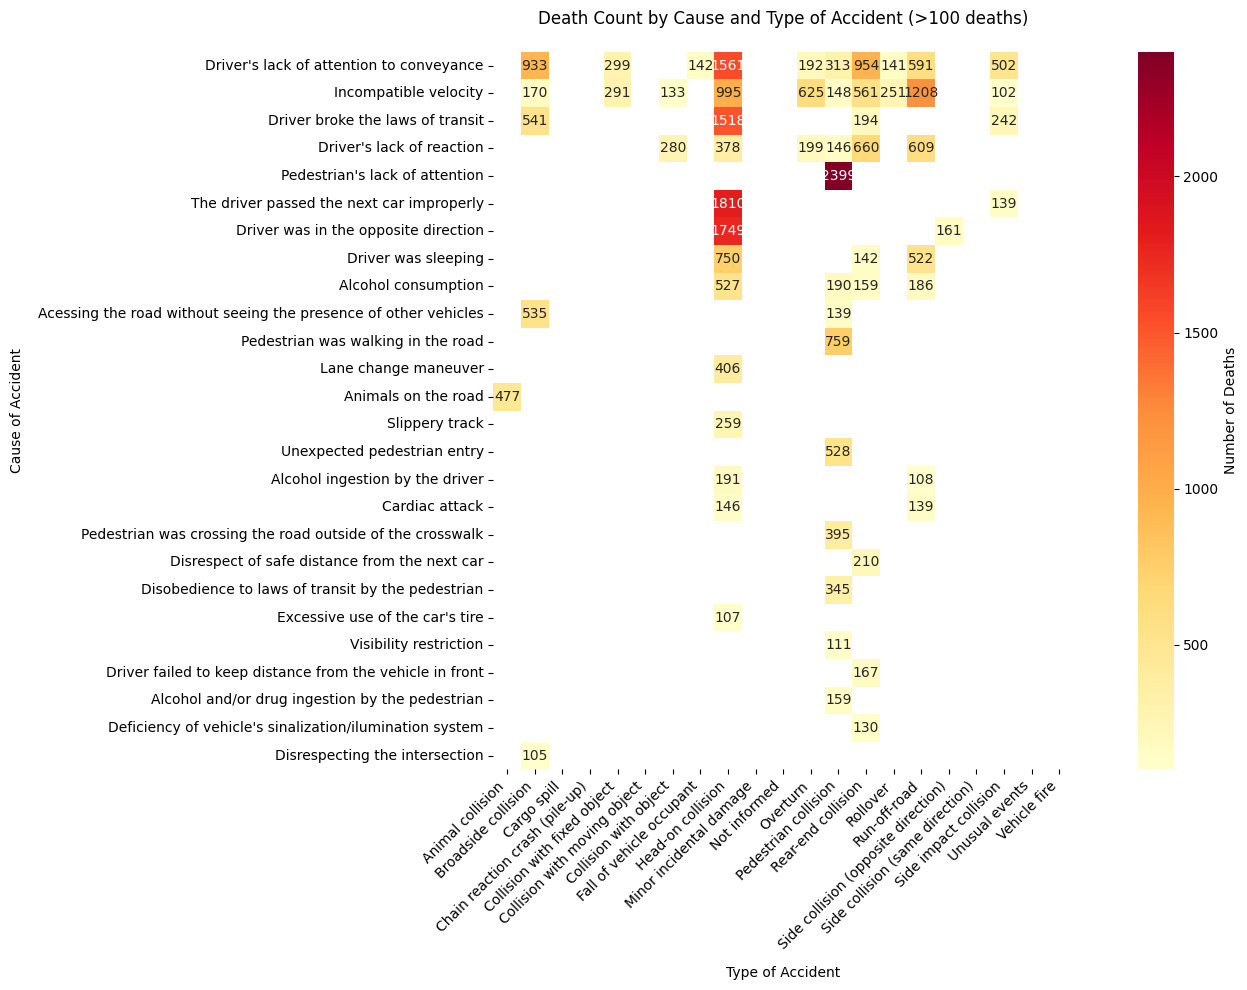

In [ ]:
def severity_analysis(df):
    """
    Analyze accident severity patterns, showing only incidents with >100 deaths
    and removing causes with no significant incidents
    """
    # Create severity heatmap with better formatting
    severity_pivot = df.pivot_table(
        index='cause_of_accident',
        columns='type_of_accident',
        values='deaths',
        aggfunc='sum'
    ).fillna(0)
    # Remove rows where all values are ≤ 100
    significant_rows = (severity_pivot > 100).any(axis=1)
    severity_pivot = severity_pivot[significant_rows]
    
    # Sort values to show most impactful causes first
    severity_pivot = severity_pivot.reindex(severity_pivot.sum(axis=1).sort_values(ascending=False).index)
    
    # Create a mask for values <= 100
    mask = severity_pivot <= 100
    
    # Only create plot if there's data to show
    if not severity_pivot.empty:
        plt.figure(figsize=(15, 10))
        sns.heatmap(severity_pivot,cmap='YlOrRd',annot=True,fmt='.0f',cbar_kws={'label': 'Number of Deaths'},
                    square=True,
                    mask=mask)
        
        plt.title('Death Count by Cause and Type of Accident (>100 deaths)', pad=20)
        plt.xlabel('Type of Accident', labelpad=10)
        plt.ylabel('Cause of Accident', labelpad=10)
        
        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        
        # Adjust layout to prevent label cutoff
        plt.tight_layout()
        plt.show()
    else:
        print("No accidents with more than 100 deaths found in the dataset.")
severity_analysis(df)

# Weather analysis

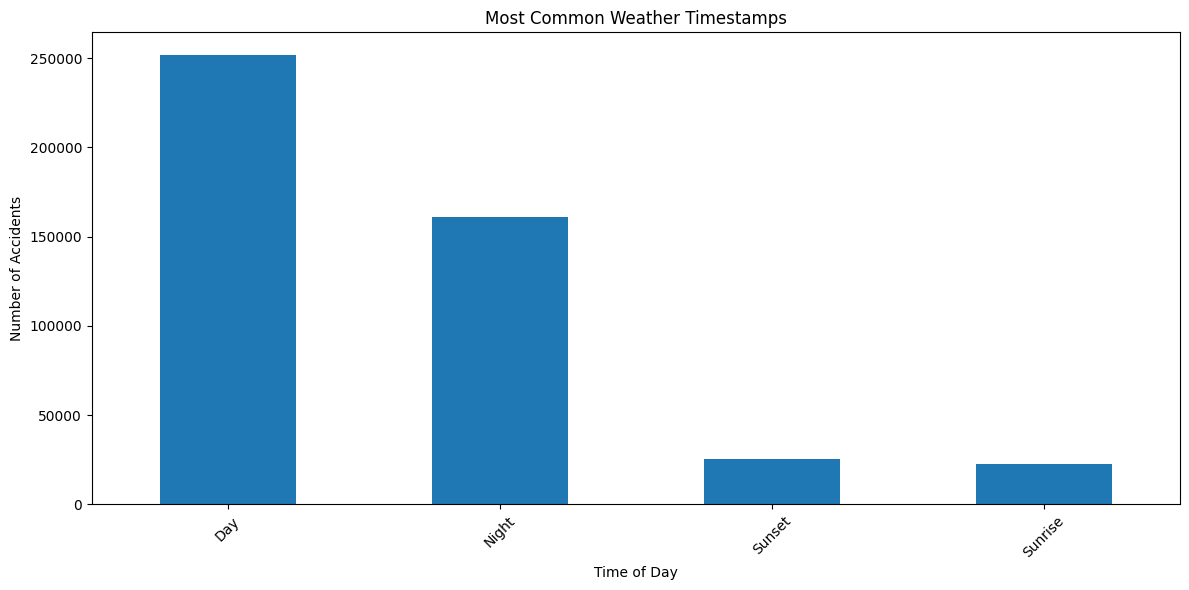

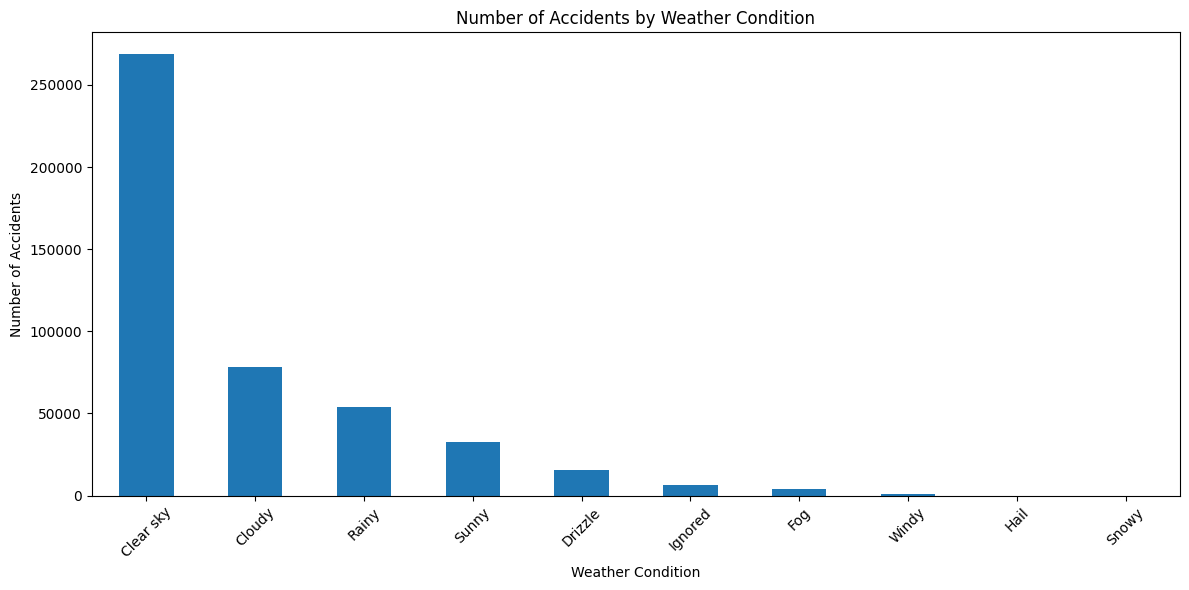

In [15]:
def weather_analysis(df):
    """Analyze weather impact on accidents"""
    # Analyze weather_timestamp patterns
    plt.figure(figsize=(12, 6))
    df['weather_timestamp'].value_counts().plot(kind='bar')
    plt.title('Most Common Weather Timestamps')
    plt.xlabel('Time of Day')
    plt.ylabel('Number of Accidents')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Weather condition analysis
    plt.figure(figsize=(12, 6))
    weather_accidents = df['wheather_condition'].value_counts()
    weather_accidents.plot(kind='bar')
    plt.title('Number of Accidents by Weather Condition')
    plt.xlabel('Weather Condition')
    plt.ylabel('Number of Accidents')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

weather_analysis(df)

# Victim analysis

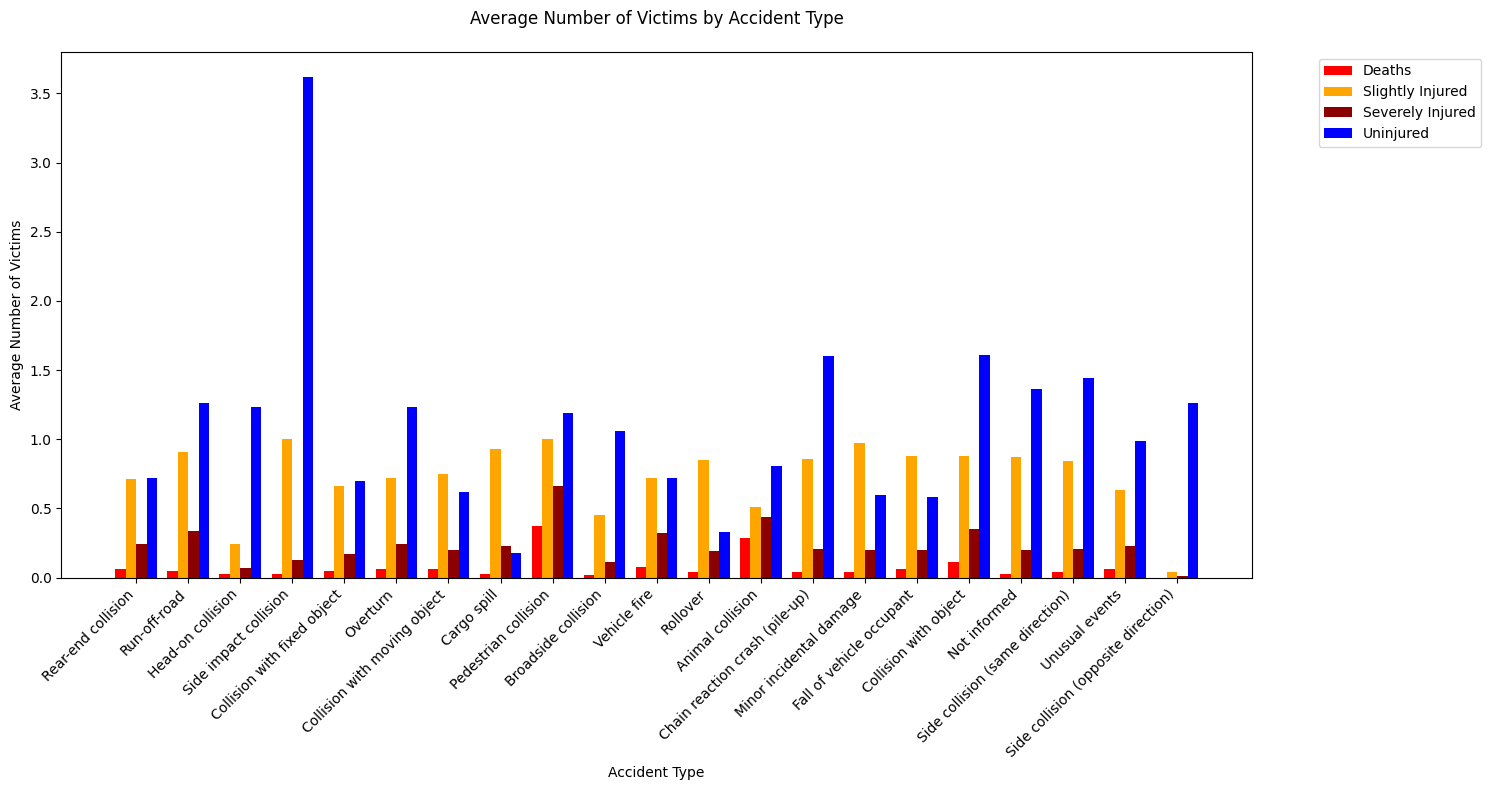

In [12]:
def victim_analysis(df):
    """Analyze victim patterns with improved visualization"""
    # Prepare data for visualization
    accident_types = df['type_of_accident'].unique()
    victim_cols = ['deaths', 'slightly_injured', 'severely_injured', 'uninjured']
    
    # Calculate average victims per accident type
    avg_victims = df.groupby('type_of_accident')[victim_cols].mean().round(2)
    
    # Create figure with adjusted size
    plt.figure(figsize=(15, 8))
    
    # Create grouped bar chart
    x = np.arange(len(accident_types))
    width = 0.2
    
    # Plot each victim type
    plt.bar(x - width*1.5, avg_victims['deaths'], width, label='Deaths', color='red')
    plt.bar(x - width/2, avg_victims['slightly_injured'], width, label='Slightly Injured', color='orange')
    plt.bar(x + width/2, avg_victims['severely_injured'], width, label='Severely Injured', color='darkred')
    plt.bar(x + width*1.5, avg_victims['uninjured'], width, label='Uninjured', color='blue')
    
    # Customize the plot
    plt.title('Average Number of Victims by Accident Type', pad=20)
    plt.xlabel('Accident Type')
    plt.ylabel('Average Number of Victims')
    
    # Set x-axis labels
    plt.xticks(x, accident_types, rotation=45, ha='right')
    
    # Add legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
victim_analysis(df)

# Road analysis

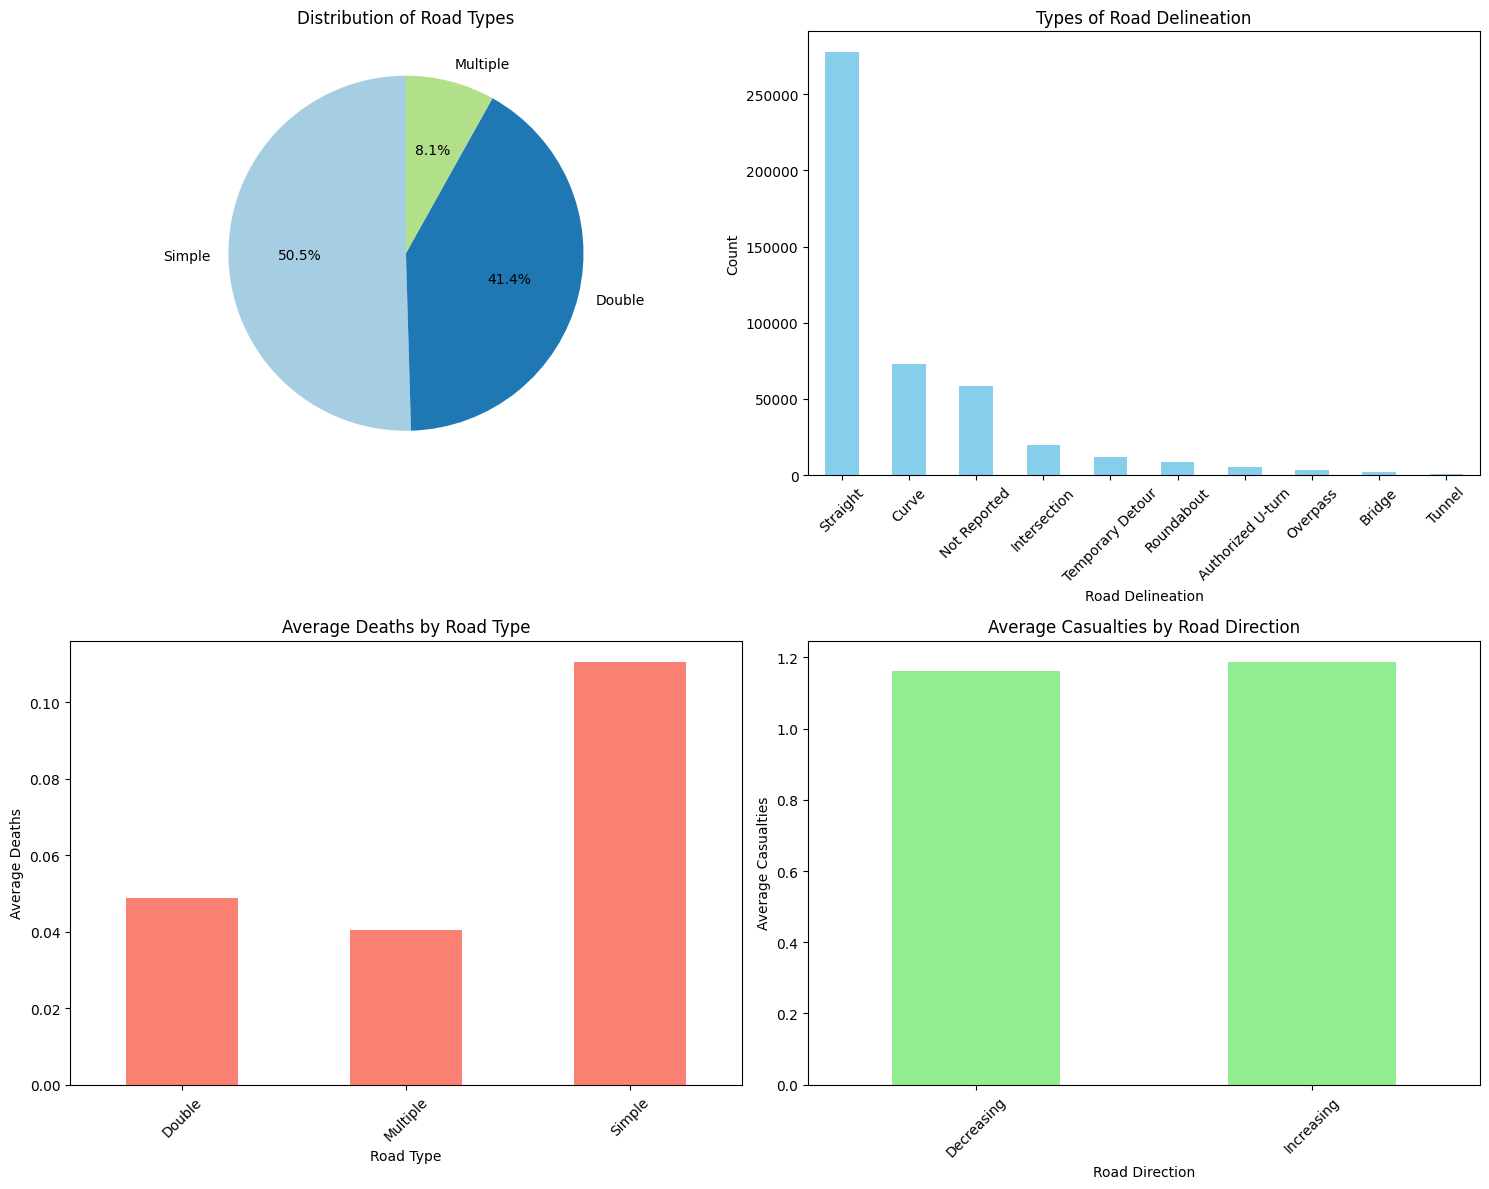

In [13]:
def road_analysis(df):
    """Analyze and visualize road-related factors."""
    
    # Set up a 2x2 grid of subplots with a larger figure size for readability
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Distribution of Road Types (Pie Chart)
    df['road_type'].value_counts().plot(
        kind='pie', 
        ax=axes[0, 0], 
        autopct='%1.1f%%', 
        startangle=90,
        colors=plt.cm.Paired.colors  # Optional color map for variety
    )
    axes[0, 0].set_title('Distribution of Road Types')
    axes[0, 0].set_ylabel('')  # Removes y-axis label for pie chart clarity
    
    # Plot 2: Types of Road Delineation (Bar Chart)
    df['road_delineation'].value_counts().plot(
        kind='bar', 
        ax=axes[0, 1],
        color='skyblue'
    )
    axes[0, 1].set_title('Types of Road Delineation')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].set_xlabel('Road Delineation')
    axes[0, 1].set_ylabel('Count')
    
    # Plot 3: Average Deaths by Road Type (Bar Chart)
    df.groupby('road_type')['deaths'].mean().plot(
        kind='bar', 
        ax=axes[1, 0],
        color='salmon'
    )
    axes[1, 0].set_title('Average Deaths by Road Type')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].set_xlabel('Road Type')
    axes[1, 0].set_ylabel('Average Deaths')
    
    # Plot 4: Average Casualties by Road Direction (Bar Chart)
    df.groupby('road_direction')['total_casualties'].mean().plot(
        kind='bar', 
        ax=axes[1, 1],
        color='lightgreen'
    )
    axes[1, 1].set_title('Average Casualties by Road Direction')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].set_xlabel('Road Direction')
    axes[1, 1].set_ylabel('Average Casualties')
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()
road_analysis(df)

# Location analysis

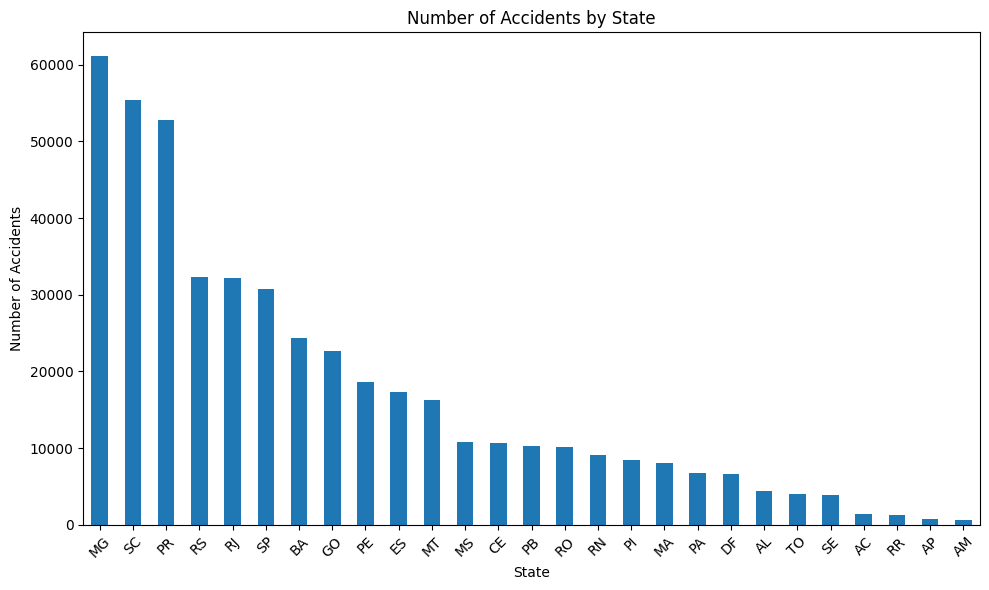

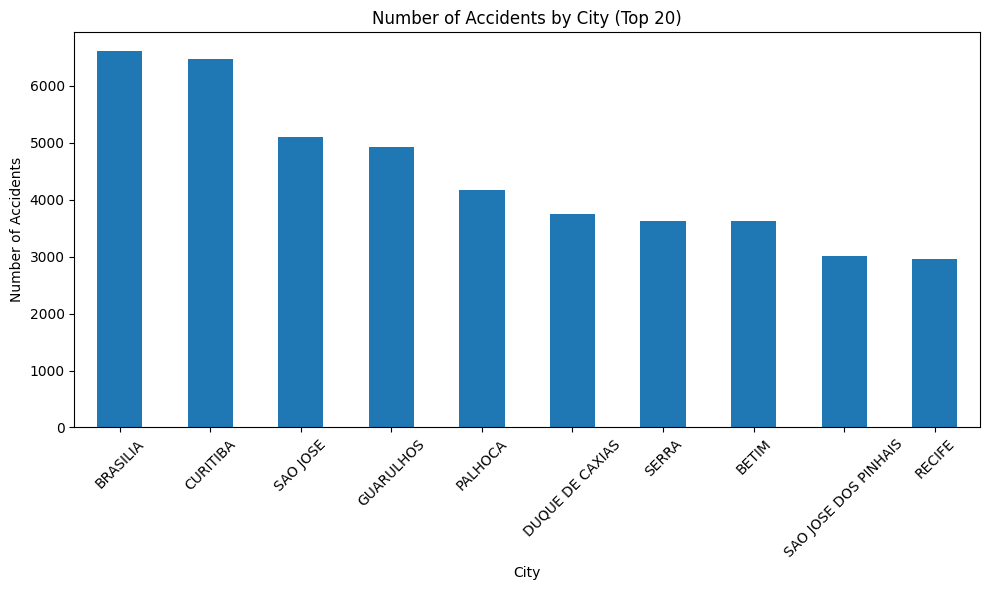

In [19]:
def location_analysis(df):
    """Analyze geographical patterns"""
    # State-wise analysis
    plt.figure(figsize=(10, 6))
    state_accidents = df['state'].value_counts()
    state_accidents.plot(kind='bar')
    plt.title('Number of Accidents by State')
    plt.xlabel('State')
    plt.ylabel('Number of Accidents')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # City analysis (top 20 cities)
    plt.figure(figsize=(10, 6))
    city_accidents = df['city'].value_counts().head(10)
    city_accidents.plot(kind='bar')
    plt.title('Number of Accidents by City (Top 20)')
    plt.xlabel('City')
    plt.ylabel('Number of Accidents')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
location_analysis(df)